<a href="https://colab.research.google.com/github/aryeko/DeepLearning-TAU/blob/Ex2-Q1/Ex2/Ex2%20-%20Q1%20-%20CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 1
You are required to present two models: 
- (i) using fully connected layers only
- (ii) combining convolution layers and fully connected layers. 

Analyze theperformance of your models.

Notes: 
- (i) For both models you may use Batchnorm and Dropout layers. 
- (ii) The models should be written in PyTorch.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

## Load the data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 50

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Let us show some of the training images

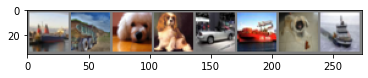

 ship truck   dog   dog   car  ship   dog  ship


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

num_samples = min(batch_size, 8)
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:num_samples]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(num_samples)))

## Use cude GPU if available 

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


## Define a fully-connected Neural Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 3 * 32 * 32
        self.fc1 = nn.Linear(self.input_size, self.input_size * 2)
        self.bn1 = nn.BatchNorm1d(self.input_size * 2)
        self.fc2 = nn.Linear(self.input_size * 2, self.input_size * 4)
        self.bn2 = nn.BatchNorm1d(self.input_size * 4)
        self.fc3 = nn.Linear(self.input_size * 4, 4096)
        self.fc4 = nn.Linear(4096, 1024)
        self.fc5 = nn.Linear(1024, 512)
        self.fc6 = nn.Linear(512, 128)
        self.fc7 = nn.Linear(128, 10)

        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

## Define a Convolutional Neural Network

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class ConvFCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3) 
        self.bn3 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 10)

        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.bn3(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

## Define network training flow

In [9]:
def train_net(net, optimizer, criterion, epochs=20, print_loss=False):
    net.to(device) # Send the betwork architecture to the GPU if available
    print_interval = int(batch_size/2)  # 2 prints per batch
    loss_values = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            # and send to GPU if possible
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % print_interval == print_interval-1: 
                loss_values.append((epoch + 1, i + 1, running_loss / (i+1)))
                if print_loss:
                  print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / (i+1)))
                running_loss = 0.0

    print('Finished Training')
    return loss_values

## Define a Loss function, optimizer and train the fully connected net
- Let's use a Classification Cross-Entropy loss and SGD with momentum.

In [ ]:
import torch.optim as optim

fc_net = FCNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fc_net.parameters(), lr=0.001, momentum=0.9)

fc_loss_vals = train_net(fc_net, optimizer, criterion)

## Define network test flow

In [16]:
def test_net(net):
  correct = 0
  total = 0
  
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          inputs, labels = data[0].to(device), data[1].to(device)
          # calculate outputs by running images through the network 
          outputs = net(inputs)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  accuracy = (100 * correct / total)
  return accuracy

## Test the fully connected network

In [ ]:
fc_accuracy = test_net(fc_net)
print(f"Fully connected accuracy: {fc_accuracy}%")

## Define a Loss function, optimizer and train the CNN
- Let's use a Classification Cross-Entropy loss and SGD with momentum.

In [ ]:
import torch.optim as optim

conv_fc_net = ConvFCNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(conv_fc_net.parameters(), lr=0.001, momentum=0.9)

conv_fc_loss_vals = train_net(conv_fc_net, optimizer, criterion)

## Test the CNN

In [ ]:
conv_fc_accuracy = test_net(conv_fc_net)
print(f"CNN accuracy: {conv_fc_accuracy}%")